In [0]:
from os.path import join
from google.colab import drive
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
 
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

import numpy as np

import tarfile
import tensorflow as tf
import zipfile
 
from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
 
ROOT = "/content/drive"
drive.mount(ROOT)
 
PROJ = "My Drive/TFConfig" # This is a custom path.
PROJECT_PATH = join(ROOT, PROJ)
 
%cd ~/content
%cd drive/My Drive/TFConfig

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: '/root/content'
/content/drive/My Drive/TFConfig/TFmodels/research/object_detection
[Errno 2] No such file or directory: 'drive/My Drive/TFConfig'
/content/drive/My Drive/TFConfig/TFmodels/research/object_detection


## Clone object detection repository and config tf object detection api

In [0]:
!git clone https://github.com/dodandeniya/TFmodels.git

fatal: destination path 'TFmodels' already exists and is not an empty directory.


In [0]:
%cd ~
%cd /content
%cd drive/My Drive/TFConfig/TFmodels/research
!pwd
!protoc object_detection/protos/*.proto --python_out=.

/root
/content
/content/drive/My Drive/TFConfig/TFmodels/research
/content/drive/My Drive/TFConfig/TFmodels/research


## Test

In [0]:
%cd ~
%cd /content
%cd drive/My Drive/TFConfig/
os.environ['PYTHONPATH'] += ':/content/drive/My Drive/TFConfig/TFmodels/research/:/content/drive/My Drive/TFConfig/TFmodels/research/slim/'
os.environ['PYTHONPATH'] += ':/content/drive/My Drive/TFConfig/TFmodels/research/:/content/drive/My Drive/TFConfig/TFmodels/research/object_detection/'
!python TFmodels/research/object_detection/builders/model_builder_test.py
 
# Change the directory path
 
%cd TFmodels/research/object_detection

/root
/content
/content/drive/My Drive/TFConfig
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Running tests under Python 3.6.9: /usr/bin/python3
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[       OK ] ModelBuilderTest.test_create_faster_rcnn_model_from_config_with_example_miner
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_with_matmul
[       OK ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_with_matmul
[ RUN      ] ModelBuilderTest.test_create_faster_rcnn_models_from_config_faster_rcnn_without_matmul
[       OK ] ModelBuilderTest.test_create_faster_rcnn_model

## Create folders

create folder "images" put images there <br>
put test_labels.csv and train_labels.csv in "data" folder <br>
creste folders "trained" and "fine_tuned_model"



## Model to work with

In [0]:
#faster_rcnn_inception_v2_coco

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
 
from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
 
# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops
 
if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')
   
%matplotlib inline
 
from utils import label_map_util
 
from utils import visualization_utils as vis_util
 
 
# Model preparation
 
# What model to download.
MODEL_NAME = 'faster_rcnn_inception_v2_coco_2018_01_28'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
 
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = '/content/drive/My Drive/TFConfig/TFmodels/research/object_detection/' + MODEL_NAME + '/frozen_inference_graph.pb'
 
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/content/drive/My Drive/TFConfig/TFmodels/research/object_detection/data', 'mscoco_label_map.pbtxt')
 
# Download Model
 
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())
     
# Load a (frozen) Tensorflow model into memory.
 
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
     
# Loading label map
 
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Generate ft.records

In [0]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import os
import io
import pandas as pd
import tensorflow as tf

from PIL import Image
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict

flags = tf.app.flags
flags.DEFINE_string('csv_input', '', 'data/train_labels.csv')
flags.DEFINE_string('output_path', '', 'data/train.record')
flags.DEFINE_string('image_dir', '', 'images/')
FLAGS = flags.FLAGS


# TO-DO replace this with label map
def class_text_to_int(row_label):
    if row_label == 'car':
        return 1
    else:
        None

def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]


def create_tf_example(group, path):
    with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

def main(_):    

    print(os.getcwd())
    writer = tf.python_io.TFRecordWriter('data/train.record')
    # path = os.path.join(FLAGS.image_dir)
    path = 'images'
    # examples = pd.read_csv(FLAGS.csv_input)
    examples = pd.read_csv('data/train_labels.csv')
    grouped = split(examples, 'filename')
    for group in grouped:
        tf_example = create_tf_example(group, path)
        writer.write(tf_example.SerializeToString())
    writer.close()
    output_path = os.path.join(os.getcwd(), FLAGS.output_path)
    print('Successfully created the TFRecords: {}'.format(output_path))


if __name__ == '__main__':
    tf.app.run()

/content/drive/My Drive/TFConfig/TFmodels/research/object_detection
Successfully created the TFRecords: /content/drive/My Drive/TFConfig/TFmodels/research/object_detection/


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [0]:
flags = tf.app.flags
flags.DEFINE_string('csv_input2', '', 'data/test_labels.csv')
flags.DEFINE_string('output_path2', '', 'data/test.record')
flags.DEFINE_string('image_dir2', '', 'images/')
FLAGS = flags.FLAGS

def class_text_to_int(row_label):
    if row_label == 'car':
        return 1
    else:
        None


def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]


def create_tf_example(group, path):
    with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

def main(_):    

    print(os.getcwd())
    writer = tf.python_io.TFRecordWriter('data/test.record')
    # path = os.path.join(FLAGS.image_dir2)
    path = 'images'
    # examples = pd.read_csv(FLAGS.csv_input2)
    examples = pd.read_csv('data/test_labels.csv')
    grouped = split(examples, 'filename')
    for group in grouped:
        tf_example = create_tf_example(group, path)
        writer.write(tf_example.SerializeToString())
    writer.close()
    output_path2 = os.path.join(os.getcwd(), FLAGS.output_path2)
    print('Successfully created the TFRecords: {}'.format(output_path2))


if __name__ == '__main__':
    tf.app.run()

/content/drive/My Drive/TFConfig/TFmodels/research/object_detection
Successfully created the TFRecords: /content/drive/My Drive/TFConfig/TFmodels/research/object_detection/


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Create label map

In [0]:
!echo "item { id: 1 name: 'car'}" > data/label_map.pbtxt

## Change model config

In [0]:
import re

filename = 'samples/configs/faster_rcnn_inception_v2_coco.config'
with open(filename) as f:
  s = f.read()

with open(filename, 'w') as f:
  
  s = re.sub('batch_size: 1', 'batch_size: 8', s)
  s = re.sub('num_classes: 90', 'num_classes: 1', s)
  s = re.sub('keep_aspect_ratio_resizer {', 'fixed_shape_resizer {', s)
  s = re.sub('min_dimension: 600', 'height: 600', s)
  s = re.sub('max_dimension: 1024', 'width: 1024', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/model.ckpt', 'pretrained_model/model.ckpt', s)
  s = re.sub("PATH_TO_BE_CONFIGURED/mscoco_train.record-\?\?\?\?\?-of-00100", 'data/train.record', s)
  s = re.sub("PATH_TO_BE_CONFIGURED/mscoco_val.record-\?\?\?\?\?-of-00010", 'data/test.record', s)
  s = re.sub("PATH_TO_BE_CONFIGURED/mscoco_label_map.pbtxt", 'data/label_map.pbtxt', s)
  f.write(s)

## Train model

In [0]:
!python model_main.py \
    --pipeline_config_path=samples/configs/faster_rcnn_inception_v2_coco.config \
    --model_dir=trained \
    --logtostderr \
    --num_train_steps=15000 \
    --num_eval_steps=500

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





W1216 07:14:28.557652 140464330405760 module_wrapper.py:139] From /content/drive/My Drive/TFConfig/TFmodels/research/object_detection/utils/config_util.py:96: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W1216 07:14:29.291282 140464330405760 module_wrapper.py:139] From /content/drive/My Drive/TFConfig/TFmodels/research/object_detection/model_lib.py:597: The name tf.logging.warning is deprecated. Please use tf.compat.v1.logging.warning instead.

W1216 07:14:29.291457 140464330405760 model_lib.py:598] Forced number of epochs for all eval validations to be 1.

W1216 07:14:29.291596 140464330405

## Export model

In [0]:
lst = os.listdir('trained')
lf = filter(lambda k: 'model.ckpt-' in k, lst)
last_model = sorted(lf)[-1].replace('.meta', '')

!python export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=samples/configs/faster_rcnn_inception_v2_coco.config \
    --output_directory=fine_tuned_model \
    --trained_checkpoint_prefix=trained/$last_model

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.





W1216 10:36:34.351837 140512250263424 module_wrapper.py:139] From export_inference_graph.py:139: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W1216 10:36:34.355481 140512250263424 module_wrapper.py:139] From /content/drive/My Drive/TFConfig/TFmodels/research/object_detection/exporter.py:357: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.


W1216 10:36:34.355843 140512250263424 module_wrapper.py:139] From /content/drive/My Drive/TFConfig/TFmodels/research/object_detection/exporter.py:110: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeh

## Inference on one image

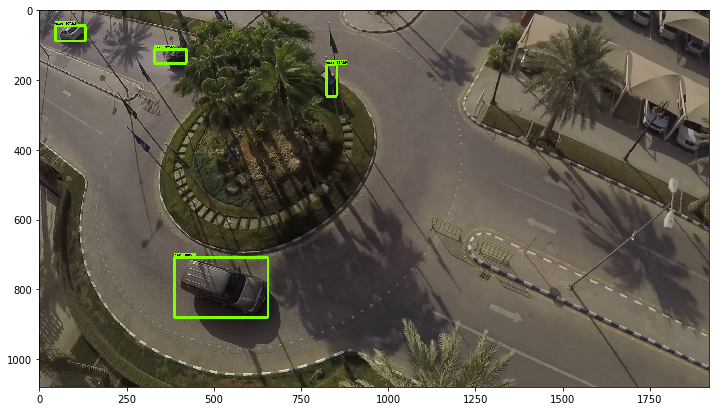

In [0]:
%matplotlib inline
# What model to download.
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = 'fine_tuned_model/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'label_map.pbtxt')

NUM_CLASSES = 1

detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
  
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'images'
TEST_IMAGE_PATHS = ['images/00481.jpg']
#TEST_IMAGE_PATHS = [os.path.join('images', 'image{}.jpg'.format(i)) for i in range(1, 2) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)